In [1]:
allow_train = True
freeze_encoder = False
EPOCHS = 5
BATCH_SIZE = 32
load_pre_train_model = False

In [2]:
import os
import torch
import torchvision
from torch import nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from torchinfo import summary
from going_modular import engine, engine_post_train, utils
from going_modular import custom_data_setup_post_train
import helper_functions

c:\Users\Amiroodi\AppData\Local\Programs\Python\Python311\Lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
no_transforms = A.Compose([
    A.Resize(240, 240),       
    A.ToFloat(),
    ToTensorV2()
], seed=33)

p = 0.3

A_transforms = A.Compose([ 
    A.Resize(240, 240),
    # A.OpticalDistortion(distort_limit=0.3, p=p),
    # A.GridDistortion(num_steps=5, distort_limit=0.3, p=p),
    # A.ElasticTransform(alpha=40, sigma=50, p=p),
    # A.Affine(scale=[0.7, 1.4], translate_percent=[-0.05, 0.05], shear=[-15, 15], rotate=[-45, 45], p=p),
    # A.HorizontalFlip(p=p), 
    # A.VerticalFlip(p=p), 
    # A.RGBShift(r_shift_limit=30, g_shift_limit=30, b_shift_limit=30, p=p),  
    # A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=p),  
    # A.AdditiveNoise(noise_type='gaussian', spatial_mode='shared', approximation=1.0, noise_params={"mean_range": (0.0, 0.0), "std_range": (0.02, 0.05)}, p=p),
    # A.GaussianBlur(blur_limit=1, p=p),
    # A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=p),  
    # A.Emboss(alpha=(0.5, 0.6), strength=(0.6, 0.7), p=p),  
    # A.RandomGamma(gamma_limit=(80, 120), p=p),  
    # A.CoarseDropout(num_holes_range=(1, 2), hole_height_range=(0.1, 0.2), hole_width_range=(0.1, 0.2), fill=0, fill_mask=None, p=p),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    A.ToFloat(),
    ToTensorV2()
], seed=33)

In [5]:
train_val_dataloader, class_names = custom_data_setup_post_train.create_train_val_dataloader(transform=A_transforms, batch_size=32, device=device, shrink_size=20)

test_dataloader, class_names = custom_data_setup_post_train.create_test_dataloader(transform=A_transforms, batch_size=32, device=device, shrink_size=20)

d:\University Project\Main Project\code\going_modular\custom_data_setup_post_train.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("mod

In [6]:
class OneHeadCNN(nn.Module):
    def __init__(self):
        super(OneHeadCNN, self).__init__()

        self.final_head = nn.Linear(3, 1)
        # self.final_head = nn.Sequential(
        #     nn.Linear(3, 5),
        #     nn.ReLU(),
        #     nn.Linear(5, 3),
        #     nn.ReLU(),
        #     nn.Linear(3, 1)
        # )

    def forward(self, x):
        return self.final_head(x)

model = OneHeadCNN().to(device)

In [7]:
# Initialize all weights to 1/3
def init_weights_custom(m):
    if isinstance(m, nn.Linear):
        nn.init.constant_(m.weight, 1/3)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

model.apply(init_weights_custom)

OneHeadCNN(
  (final_head): Linear(in_features=3, out_features=1, bias=True)
)

In [ ]:
# Define loss and optimizer
from torch.optim.lr_scheduler import CosineAnnealingLR

loss_fn = nn.MSELoss().to(device)

optimizer = torch.optim.RAdam(model.parameters(), lr=0.2, weight_decay=1e-3)
scheduler = CosineAnnealingLR(optimizer, T_max=5, eta_min=0.001)

In [9]:
folds_train_results = {
    'loss_train': []
}
folds_val_results = {
    'loss_val': []
}
if allow_train:
    # Set the random seeds
    torch.manual_seed(42)
    torch.cuda.manual_seed(42)

    # Start the timer
    from timeit import default_timer as timer 
    start_time = timer()

    # Setup training and save the results
    for fold in train_val_dataloader:
        train_results, val_results = engine_post_train.train(model=model,
                            train_dataloader=fold['train_dataloader'],
                            val_dataloader=fold['val_dataloader'],
                            optimizer=optimizer,
                            scheduler=scheduler,
                            loss_fn=loss_fn,
                            epochs=EPOCHS,
                            device=device)
        
        # helper_functions.plot_loss_curves(results)
        folds_train_results['loss_train'].extend(train_results['loss_train'])

        folds_val_results['loss_val'].extend(val_results['loss_val'])

    # End the timer and print out how long it took
    end_time = timer()
    print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

    utils.save_model(model=model, target_dir='models', model_name='post_train_model.pth')
else:
    model.load_state_dict(torch.load('models/post_train_model.pth', weights_only=True, map_location=device))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
loss_train: 0.0278 | loss_val: 0.6242 | acc_val: 0.0000

Epoch: 2
loss_train: 1.1684 | loss_val: 0.5585 | acc_val: 0.0000

Epoch: 3
loss_train: 1.0468 | loss_val: 0.2716 | acc_val: 0.7500

Epoch: 4
loss_train: 0.5157 | loss_val: 0.1249 | acc_val: 1.0000

Epoch: 5
loss_train: 0.2395 | loss_val: 0.0893 | acc_val: 1.0000



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
loss_train: 0.1500 | loss_val: 0.1731 | acc_val: 1.0000

Epoch: 2
loss_train: 0.1498 | loss_val: 0.1688 | acc_val: 1.0000

Epoch: 3
loss_train: 0.1459 | loss_val: 0.1509 | acc_val: 1.0000

Epoch: 4
loss_train: 0.1295 | loss_val: 0.1153 | acc_val: 1.0000

Epoch: 5
loss_train: 0.0972 | loss_val: 0.0708 | acc_val: 1.0000



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
loss_train: 0.0545 | loss_val: 0.0346 | acc_val: 1.0000

Epoch: 2
loss_train: 0.0266 | loss_val: 0.0075 | acc_val: 1.0000

Epoch: 3
loss_train: 0.0189 | loss_val: 0.0004 | acc_val: 1.0000

Epoch: 4
loss_train: 0.0250 | loss_val: 0.0002 | acc_val: 1.0000

Epoch: 5
loss_train: 0.0301 | loss_val: 0.0003 | acc_val: 1.0000



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
loss_train: 0.0191 | loss_val: 0.0494 | acc_val: 1.0000

Epoch: 2
loss_train: 0.0191 | loss_val: 0.0501 | acc_val: 1.0000

Epoch: 3
loss_train: 0.0193 | loss_val: 0.0499 | acc_val: 1.0000

Epoch: 4
loss_train: 0.0193 | loss_val: 0.0455 | acc_val: 1.0000

Epoch: 5
loss_train: 0.0177 | loss_val: 0.0362 | acc_val: 1.0000



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
loss_train: 0.0194 | loss_val: 0.0164 | acc_val: 1.0000

Epoch: 2
loss_train: 0.0160 | loss_val: 0.0187 | acc_val: 1.0000

Epoch: 3
loss_train: 0.0159 | loss_val: 0.0221 | acc_val: 1.0000

Epoch: 4
loss_train: 0.0172 | loss_val: 0.0234 | acc_val: 1.0000

Epoch: 5
loss_train: 0.0178 | loss_val: 0.0235 | acc_val: 1.0000

[INFO] Total training time: 0.069 seconds
[INFO] Saving model to: models\post_train_model.pth


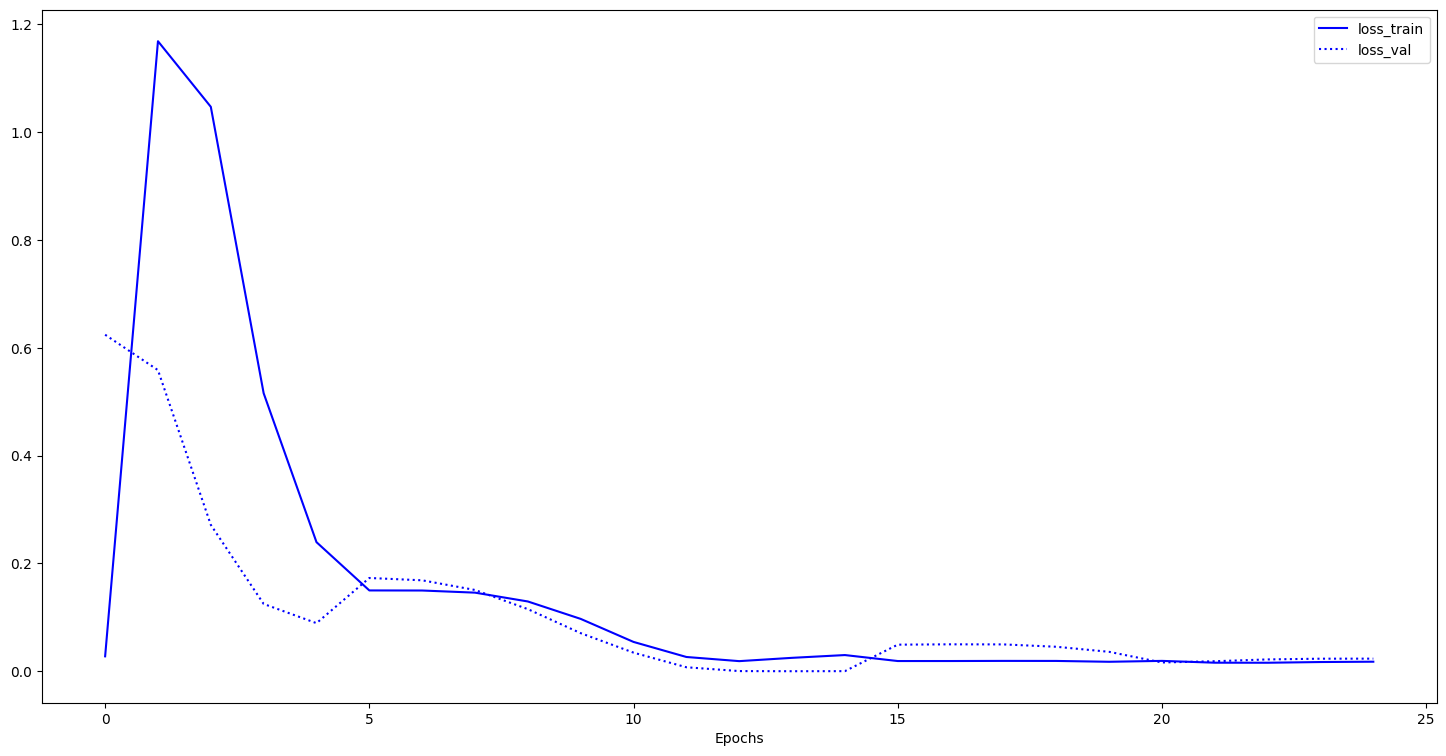

In [10]:
helper_functions.plot_loss_curves_post_train(folds_train_results, folds_val_results)

In [11]:
test_results = engine_post_train.test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device)

test acc: 0.05
